### Individual Exploratory Data Analysis (EDA) #1

Data Subject: Vehicle Emissions Dataset

Original Data Link: https://www.kaggle.com/datasets/brsahan/vehicle-co2-emissions-dataset

**Process Steps:**  
    0.0 Download Data from Internet or other source  
    0.1 Place data into project repository
    0.2 Import needed dependencies 
    ---  
    1 Read data (initial statistics, column head)  
    2 Transform/clean where needed (strip, lower, rename, replace)  
    3 Push data to an appropriate container (database)  
    4 Generate basic statistics  
    5 Generate functions for visualizations  
    6 Assess visualizations and statistical data.   

**Step 0.2**  
Import needed dependencies.

In [18]:
# Core libraries
import pandas as pd
import numpy as np
import sqlite3
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning (we’ll use later)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Change to project root (adjust as needed)
os.chdir("C:/Projects/Emissions_Analysis_Capstone")

**Step 1**  
-Obtain and connect to data.  
-Print the first few columns.

In [19]:
# File paths
vehicle_path = "raw_data/vehicle_co2.csv"

# Load CSVs
vehicle_df = pd.read_csv(vehicle_path)

# Preview data
print("Vehicle dataset shape:", vehicle_df.shape)
display(vehicle_df.head())

Vehicle dataset shape: (7385, 12)


,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


**Step 2**  
-Develop data path  
-Connect to source data  
-Clean as needed  
    ---Drop Duplicates  
    ---Fill empty values  
    ---Strip whitespace  
    ---Force lowercase  
    ---Replace spaces with underscore  
    ---Replace non-alphanumeric with underscore   

In [104]:
# --- paths ---
vehicle_csv_path = r'C:\Projects\Emissions_Analysis_Capstone\raw_data\vehicle_co2.csv'
db_path = os.path.join('emissions_data', 'emissionsdata.sqlite')
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# --- read csv robustly ---
vehicle_df = pd.read_csv(vehicle_csv_path, sep=',', engine='python', encoding='utf-8-sig', skipinitialspace=True)

# Drop duplicate rows
vehicle_df.drop_duplicates(inplace=True)

# Handle missing values (basic strategy)
vehicle_df.fillna(0, inplace=True)

# --- stricter cleaning of column names ---
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()                      # trim whitespace ends
        .str.lower()                      # lowercase
        .str.replace(r'\s+', '_', regex=True)   # spaces -> underscore
        .str.replace(r'[^\w]', '', regex=True)  # remove non-alphanumeric/underscore
    )
    return df

vehicle_df = clean_columns(vehicle_df)

print("CLEANED COLUMNS:")
print(vehicle_df.columns.tolist())

# --- mapping of the specific columns you want ---
# User requested original human headers:
# "Make", "Model", "Cylinders", "Fuel Type", "Fuel Consumption Comb (mpg)", "CO2 Emissions (g/km)"
# After cleaning these should be:
wanted_map = {
    'make': 'make',
    'model': 'model',
    'cylinders': 'cylinders',
    'fuel_type': 'fuel_type',
    'fuel_consumption_comb_mpg': 'fuel_consumption_mpg',   # rename to simpler name
    'co2_emissionsgkm': 'co2_emissions_g_per_km'
}

# Pick the intersection of available cleaned columns and the ones we want
available_source_cols = [src for src in wanted_map.keys() if src in vehicle_df.columns]
if not available_source_cols:
    raise RuntimeError("None of the expected columns found in vehicle_df. Columns found: "
                       + ", ".join(vehicle_df.columns.tolist()))

# Create the subset, then rename to the final column names
vehicle_subset = vehicle_df.loc[:, available_source_cols].copy()
vehicle_subset.rename(columns={k: wanted_map[k] for k in available_source_cols}, inplace=True)
# 1 kg = 1000 g
vehicle_subset['co2_emissions_kg'] = vehicle_subset['co2_emissions_g_per_km'] / 1000


CLEANED COLUMNS:
['make', 'model', 'vehicle_class', 'engine_sizel', 'cylinders', 'transmission', 'fuel_type', 'fuel_consumption_city_l100_km', 'fuel_consumption_hwy_l100_km', 'fuel_consumption_comb_l100_km', 'fuel_consumption_comb_mpg', 'co2_emissionsgkm']


**Step 3**  
-Select subset of columns desired  
-Prepare selected columns for database  
-Connect to database  
    ---Create new table  
-Write column data to new table  
-Print initial rows 

In [129]:

# --- Debugging prints: ensure correct shape & columns BEFORE writing ---
print("\nVEHICLE SUBSET SHAPE:", vehicle_subset.shape)
print("VEHICLE SUBSET COLUMNS:", vehicle_subset.columns.tolist())
print("\nVEHICLE SUBSET HEAD:")
print(vehicle_subset.head().to_string())

# --- Write to SQLite ---
conn = sqlite3.connect(db_path)
vehicle_subset.to_sql('vehicle_emissions', conn, if_exists='replace', index=False)




VEHICLE SUBSET SHAPE: (6282, 7)
VEHICLE SUBSET COLUMNS: ['make', 'model', 'cylinders', 'fuel_type', 'fuel_consumption_mpg', 'co2_emissions_g_per_km', 'co2_emissions_kg']

VEHICLE SUBSET HEAD:
    make       model  cylinders fuel_type  fuel_consumption_mpg  co2_emissions_g_per_km  co2_emissions_kg
0  ACURA         ILX          4         Z                    33                     196             0.196
1  ACURA         ILX          4         Z                    29                     221             0.221
2  ACURA  ILX HYBRID          4         Z                    48                     136             0.136
3  ACURA     MDX 4WD          6         Z                    25                     255             0.255
4  ACURA     RDX AWD          6         Z                    27                     244             0.244


6282

**Step 4**  
-Generate basic statistics

In [130]:
# --- Verify DB schema and a few rows from SQLite (definitive check) ---
print("\nPRAGMA table_info(vehicle_emissions):")
print(pd.read_sql("PRAGMA table_info(vehicle_emissions);", conn).to_string(index=False))

print("\nFirst 3 rows from vehicle_emissions:")
print(pd.read_sql("SELECT * FROM vehicle_emissions LIMIT 7;", conn).to_string(index=False))

# --- Final column list printout ---
print("Vehicle columns:", vehicle_df.columns.tolist())

# Load data back from SQLite to verify
vehicle_data = pd.read_sql("SELECT * FROM vehicle_emissions", conn)


PRAGMA table_info(vehicle_emissions):
 cid                   name    type  notnull dflt_value  pk
   0                   make    TEXT        0       None   0
   1                  model    TEXT        0       None   0
   2              cylinders INTEGER        0       None   0
   3              fuel_type    TEXT        0       None   0
   4   fuel_consumption_mpg INTEGER        0       None   0
   5 co2_emissions_g_per_km INTEGER        0       None   0
   6       co2_emissions_kg    REAL        0       None   0

First 3 rows from vehicle_emissions:
 make      model  cylinders fuel_type  fuel_consumption_mpg  co2_emissions_g_per_km  co2_emissions_kg
ACURA        ILX          4         Z                    33                     196             0.196
ACURA        ILX          4         Z                    29                     221             0.221
ACURA ILX HYBRID          4         Z                    48                     136             0.136
ACURA    MDX 4WD          6        

**Step 5**  
-Generate basic visualizations

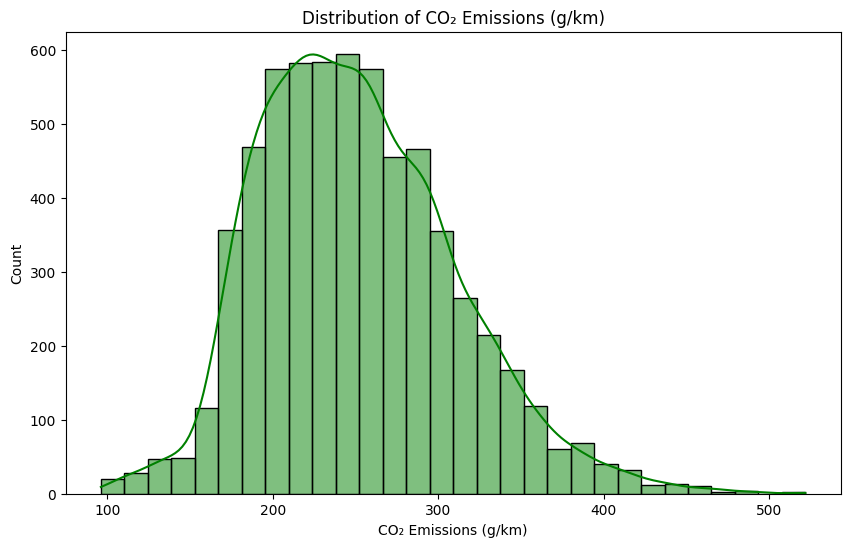

In [131]:
# Basic statistics
plt.figure(figsize=(10,6))
sns.histplot(vehicle_subset['co2_emissions_g_per_km'], bins=30, kde=True, color='green')
plt.title('Distribution of CO₂ Emissions (g/km)')
plt.xlabel('CO₂ Emissions (g/km)')
plt.ylabel('Count')
plt.show()

**Step 5**  
-Generate basic visualizations

C:\Users\derek\AppData\Local\Temp\ipykernel_2516\2277446692.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


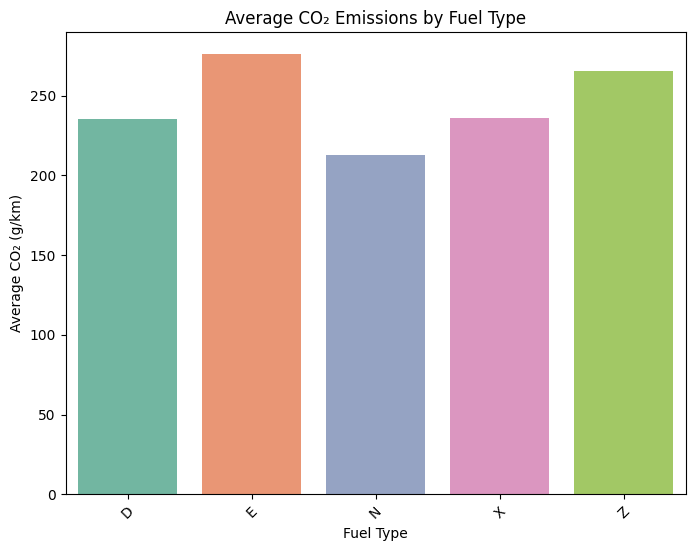

In [132]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=vehicle_subset.groupby('fuel_type', as_index=False)['co2_emissions_g_per_km'].mean(),
    x='fuel_type', y='co2_emissions_g_per_km', palette='Set2'
)
plt.title('Average CO₂ Emissions by Fuel Type')
plt.ylabel('Average CO₂ (g/km)')
plt.xlabel('Fuel Type')
plt.xticks(rotation=45)
plt.show()

**Step 5**  
-Generate basic visualizations

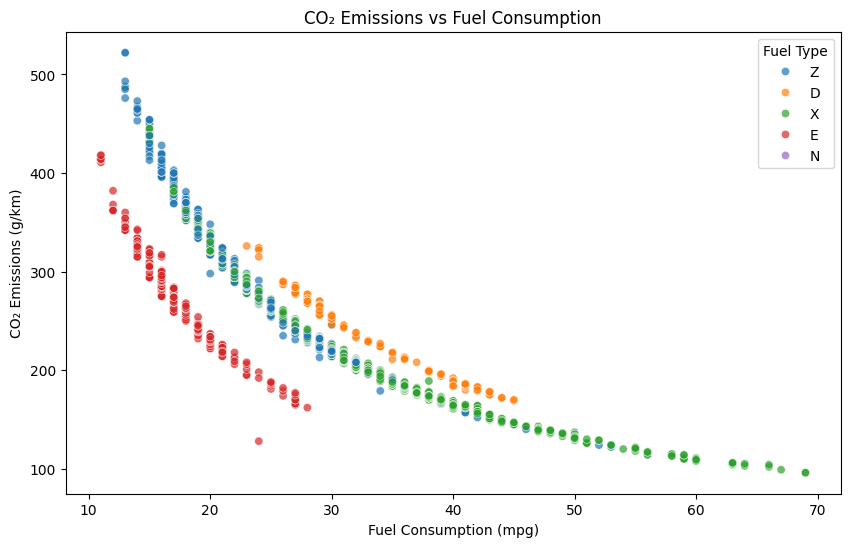

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=vehicle_subset,
    x='fuel_consumption_mpg',
    y='co2_emissions_g_per_km',
    hue='fuel_type',
    palette='tab10',
    alpha=0.7
)
plt.title('CO₂ Emissions vs Fuel Consumption')
plt.xlabel('Fuel Consumption (mpg)')
plt.ylabel('CO₂ Emissions (g/km)')
plt.legend(title='Fuel Type')
plt.show()

**Step 5**  
-Generate basic visualizations

C:\Users\derek\AppData\Local\Temp\ipykernel_2516\209333579.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_makes, x='make', y='co2_emissions_g_per_km', palette='coolwarm')


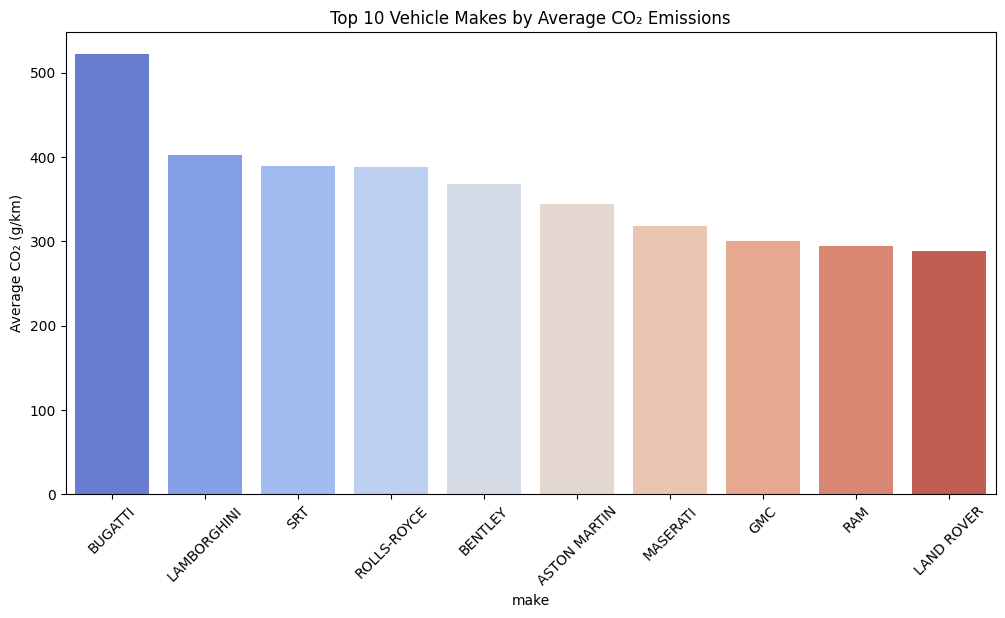

In [ ]:
top_makes = (
    vehicle_subset.groupby('make')['co2_emissions_g_per_km']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=top_makes, x='make', y='co2_emissions_g_per_km', palette='coolwarm')
plt.title('Top 10 Vehicle Makes by Average CO₂ Emissions')
plt.xticks(rotation=45)
plt.ylabel('Average CO₂ (g/km)')
plt.show()

**Step 5**  
-Generate basic visualizations

C:\Users\derek\AppData\Local\Temp\ipykernel_2516\3022222208.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_makes, x='make', y='co2_emissions_g_per_km', palette='coolwarm')


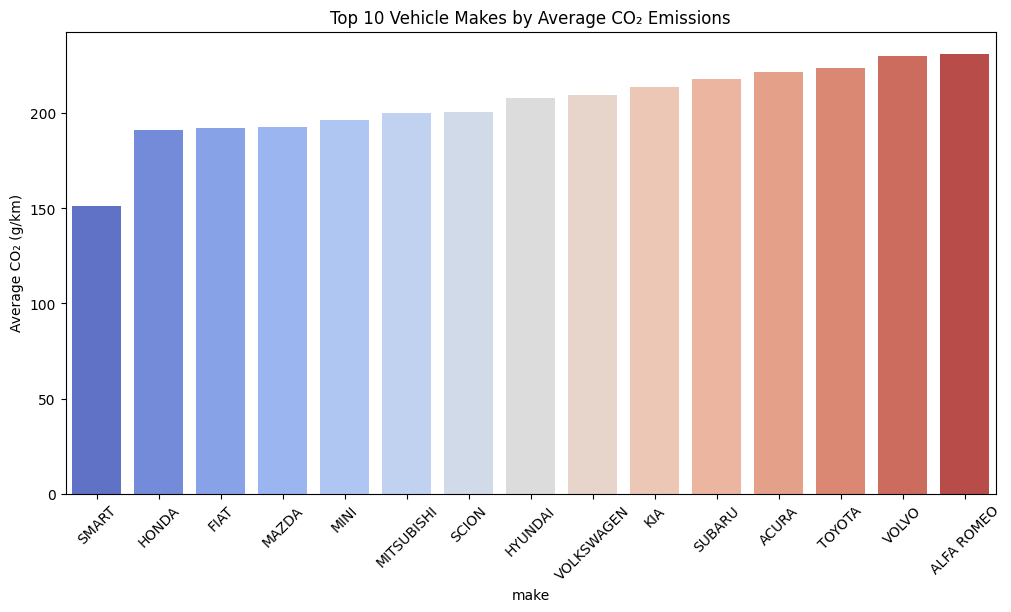

In [ ]:
top_makes = (
    vehicle_subset.groupby('make')['co2_emissions_g_per_km']
    .mean()
    .sort_values(ascending=True)
    .head(15)
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(data=top_makes, x='make', y='co2_emissions_g_per_km', palette='coolwarm')
plt.title('Top 10 Vehicle Makes by Average CO₂ Emissions')
plt.xticks(rotation=45)
plt.ylabel('Average CO₂ (g/km)')
plt.show()

**Step 5**  
-Generate basic visualizations

C:\Users\derek\AppData\Local\Temp\ipykernel_2516\512145931.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=vehicle_subset, x='cylinders', y='co2_emissions_g_per_km', palette='muted')


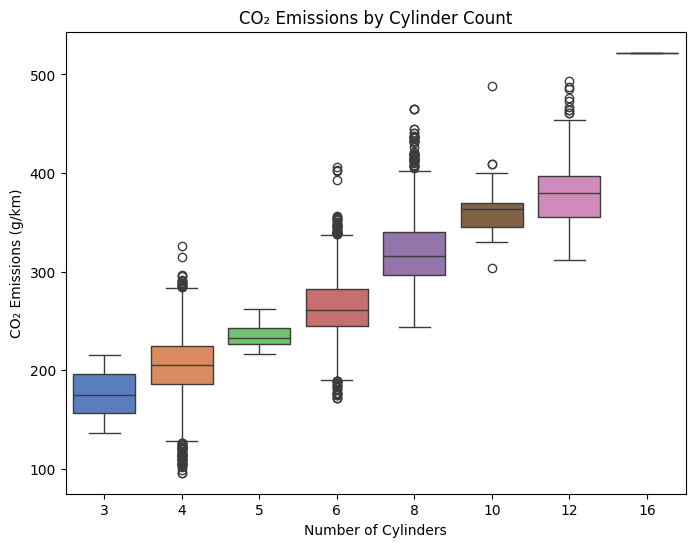

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=vehicle_subset, x='cylinders', y='co2_emissions_g_per_km', palette='muted')
plt.title('CO₂ Emissions by Cylinder Count')
plt.xlabel('Number of Cylinders')
plt.ylabel('CO₂ Emissions (g/km)')
plt.show()

**Step 5**  
-Generate basic visualizations

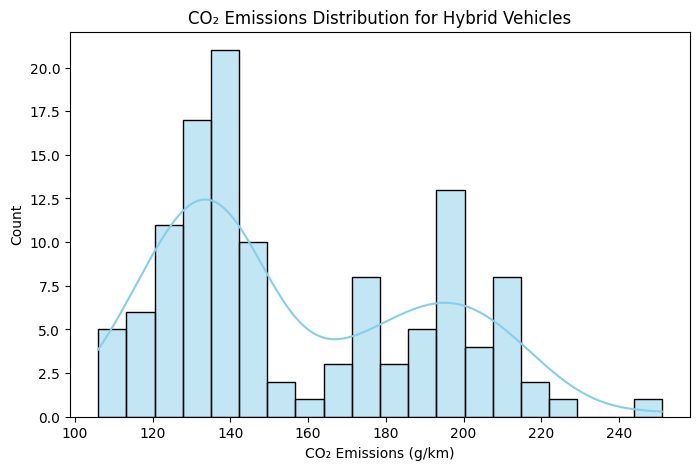

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(hybrid_vehicles['co2_emissions_g_per_km'], bins=20, kde=True, color='skyblue')
plt.title('CO₂ Emissions Distribution for Hybrid Vehicles')
plt.xlabel('CO₂ Emissions (g/km)')
plt.ylabel('Count')
plt.show()

**Step 5**  
-Generate basic visualizations

C:\Users\derek\AppData\Local\Temp\ipykernel_2516\977360465.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


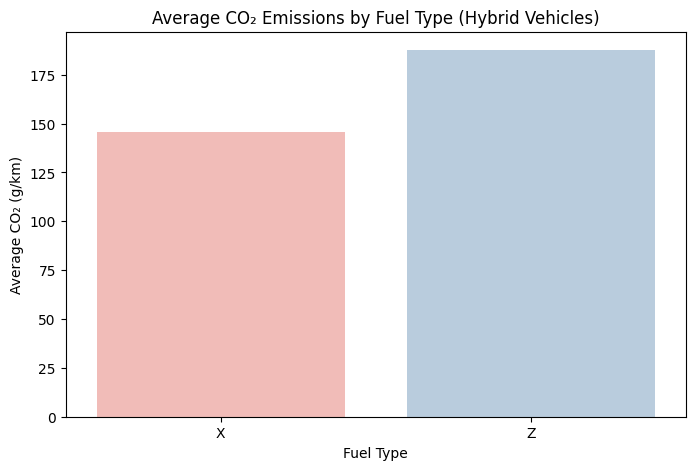

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=hybrid_vehicles.groupby('fuel_type', as_index=False)['co2_emissions_g_per_km'].mean(),
    x='fuel_type', y='co2_emissions_g_per_km', palette='Pastel1'
)
plt.title('Average CO₂ Emissions by Fuel Type (Hybrid Vehicles)')
plt.ylabel('Average CO₂ (g/km)')
plt.xlabel('Fuel Type')
plt.show()

**Step 5**  
-Generate basic visualizations

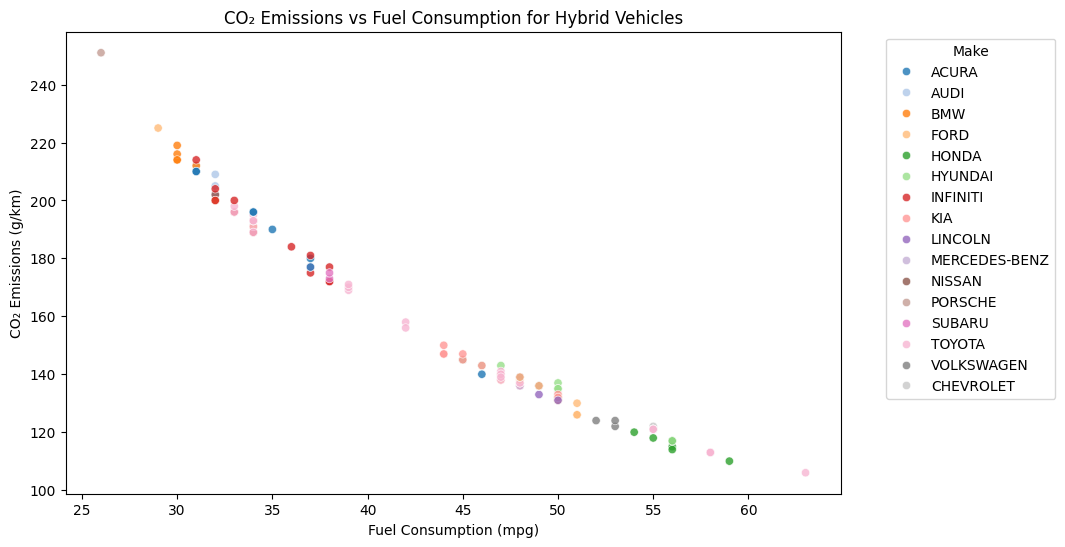

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=hybrid_vehicles,
    x='fuel_consumption_mpg',
    y='co2_emissions_g_per_km',
    hue='make',
    palette='tab20',
    alpha=0.8
)
plt.title('CO₂ Emissions vs Fuel Consumption for Hybrid Vehicles')
plt.xlabel('Fuel Consumption (mpg)')
plt.ylabel('CO₂ Emissions (g/km)')
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Step 6** 
-Assess visualizations and statistics 

In [143]:
# Create a boolean mask where 'model' contains the word 'hybrid' (case-insensitive)
hybrid_mask = vehicle_subset['model'].str.contains('hybrid', case=False, na=False)

# Filter the dataframe
hybrid_vehicles = vehicle_subset[hybrid_mask]

print(f"Found {len(hybrid_vehicles)} hybrid vehicles.")
display(hybrid_vehicles.head())

Found 121 hybrid vehicles.


,make,model,cylinders,fuel_type,fuel_consumption_mpg,co2_emissions_g_per_km,co2_emissions_kg
2,ACURA,ILX HYBRID,4,Z,48,136,0.136
42,AUDI,Q5 HYBRID,4,Z,31,212,0.212
113,BMW,ACTIVEHYBRID 3,6,Z,34,191,0.191
114,BMW,ACTIVEHYBRID 5,6,Z,30,214,0.214
115,BMW,ACTIVEHYBRID 7L,6,Z,31,212,0.212


**Step 6** 
-Assess visualizations and statistics 

In [144]:
print("Vehicle CO₂ emissions (kg) stats:")
print(vehicle_subset['co2_emissions_kg'].describe())

Vehicle CO₂ emissions (kg) stats:
count    6282.000000
mean        0.251158
std         0.059290
min         0.096000
25%         0.208000
50%         0.246000
75%         0.289000
max         0.522000
Name: co2_emissions_kg, dtype: float64
